# import Section

In [201]:
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup as bs
from tqdm import tqdm

# constant Section

In [206]:
mainUrl = 'https://habr.com/ru/post/'
postCount = 1000
habrParse_df = pd.DataFrame(columns=['num', 'URL', 'Title', 'Post', 'tags', 'hubs'])

# code Section

In [207]:
def executePost(page):
    soup = bs(page.text, 'html.parser')
    #print(soup.prettify()) # - Вывод кода страницы в хорошо читаемом виде

    # Получаем заголовок статьи
    title = soup.find('meta', property='og:title')
    title = str(title).split('="')[1].split('" ')[0]
    #print(title)
    # -------------------------

    # Получаем текст статьи
    post = str(soup.find('div', id="post-content-body"))
    post = re.sub('\n', ' ', post)
    post = re.sub('\r', ' ', post)
    post = re.sub('<br/>', ' ', post)
    post = re.sub('<b>', ' ', post)
    post = re.sub('</b>', ' ', post)
    post = re.sub('<i>', ' ', post)
    post = re.sub('</i>', ' ', post)
    post = re.sub('<strong>', ' ', post)
    post = re.sub('</strong>', ' ', post)
    post = re.sub('\s+', ' ', post)
    post = re.sub('<a href=.+?">', '', post)
    post = re.sub('<a class=""user_link"" href=".+?">', '', post)
    post = re.sub('<img.+?>', '', post)
    post = re.sub('<.img>', '', post)
    post = re.sub('</a>', '', post)
    post = post.strip()
    post = post.split('id="post-content-body">')[1].split('</div>')[0]
    
    try:
        post = post.split('<div xmlns="http://www.w3.org/1999/xhtml">')[1]
    except:
        pass

    try:
        tags = list()
        tags_list = soup.find('ul', attrs={'class' : 'tm-separated-list__list'}).find_all('li', attrs={'class' : 'tm-separated-list__item'})
        for tag in tags_list:
            tags.append(tag.text)
    except:
        tags = ''

    try:
        hubs = list()
        hubs_list = soup.find_all('ul', attrs={'class' : 'tm-separated-list__list'})[1].find_all('li', attrs={'class' : 'tm-separated-list__item'})
        for hub in hubs_list:
            hubs.append(hub.text.strip())
    except:
        hubs = ''

    return title, post, tags, hubs

In [208]:
def get_post(postNum):
    currPostUrl = mainUrl + str(postNum)
    #print(postNum, currPostUrl)
    try:
        response = requests.get(currPostUrl)
        response.raise_for_status()
        #print(response.status_code, 'OK - this post exist')

        # Отправляем полученную страницу на обработку
        #executePost(response)

        # Отправляем полученную страницу на обработку
        response_title, response_post, response_tags, response_hubs = executePost(response)

        # Записываем данные в DataFrame
        dataList = [postNum, currPostUrl, response_title, response_post, 
                    response_tags, response_hubs]
        habrParse_df.loc[len(habrParse_df)] = dataList

    except requests.exceptions.HTTPError as err:
        pass

In [209]:
for pc in tqdm(range(postCount)):
    postNum = pc + 1
    get_post(postNum)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:24<00:00,  2.60it/s]


In [210]:
habrParse_df['num'] = habrParse_df['num'].astype(int)

In [211]:
habrParse_df.head()

,num,URL,Title,Post,tags,hubs
0,1,https://habr.com/ru/post/1,Wiki-FAQ для Хабрахабра,Привет! Для сборника ответов на Часто Задаваем...,"[хабрахаб, wiki, FAQ, ЧАВО, механизм, движок]",[Habr]
1,2,https://habr.com/ru/post/2,Мы знаем много недоделок на сайте… но!,"Кроме неработающих и отсутствующих страниц, о ...","[ошибки, баги, bugs, error, warning]",[Habr]
2,4,https://habr.com/ru/post/4,"Маслов, Сокур и партнеры пиарят Google в России","Насколько я знаю, Google выбрал агентство «Мас...","[Google, Маслов, Сокур и партнеры, PR, сопрово...",[Чулан]
3,6,https://habr.com/ru/post/6,Подкасты на Хабрахабре,Мы планируем добавить в раздел «тексты» возмож...,"[хабрахабр, подкасты, mp3, контент, тексты]",[Habr]
4,7,https://habr.com/ru/post/7,Самопроизвольное разлогинивание,"У меня такое ощущение, что logout время от вре...","[логин, login]",[Habr]


In [212]:
habrParse_df.shape

(848, 6)

In [213]:
habrParse_df['post_length'] = habrParse_df['Post'].map(lambda x: len(x.split(' ')))

In [214]:
habrParse_df.to_csv('habrParse_df_.csv')

In [215]:
habrParse_df.describe()

,num,post_length
count,848.000000,848.000000
mean,504.218160,105.333726
std,285.698553,180.021672
min,1.000000,1.000000
25%,259.750000,30.000000
50%,512.500000,58.500000
75%,751.250000,116.250000
max,1000.000000,2985.000000


In [216]:
habrParse_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848 entries, 0 to 847
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   num          848 non-null    int32 
 1   URL          848 non-null    object
 2   Title        848 non-null    object
 3   Post         848 non-null    object
 4   tags         848 non-null    object
 5   hubs         848 non-null    object
 6   post_length  848 non-null    int64 
dtypes: int32(1), int64(1), object(5)
memory usage: 49.7+ KB


In [217]:
response = requests.get('https://habr.com/ru/post/491974')
soup = bs(response.text, 'html.parser')
#soup

In [219]:
from pprint import pprint

In [220]:
hubs = list()
hubs_list = soup.find_all('ul', attrs={'class' : 'tm-separated-list__list'})[1].find_all('li', attrs={'class' : 'tm-separated-list__item'})
for hub in hubs_list:
    hubs.append(hub.text.strip())
print(hubs)

['Открытые данные', 'Визуализация данных', 'Научно-популярное', 'Биотехнологии', 'Здоровье']


In [221]:
import pandas as pd
habrParse_df = pd.read_csv('habrParse_df_.csv', usecols=['Post', 'hubs'])

In [222]:
habrParse_df.head()

,Post,hubs
0,Привет! Для сборника ответов на Часто Задаваем...,['Habr']
1,"Кроме неработающих и отсутствующих страниц, о ...",['Habr']
2,"Насколько я знаю, Google выбрал агентство «Мас...",['Чулан']
3,Мы планируем добавить в раздел «тексты» возмож...,['Habr']
4,"У меня такое ощущение, что logout время от вре...",['Habr']


In [223]:
habrParse_df = habrParse_df.astype({"Post": str})

In [224]:
habrParse_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Post    848 non-null    object
 1   hubs    848 non-null    object
dtypes: object(2)
memory usage: 13.4+ KB


In [225]:
from wordcloud import WordCloud, STOPWORDS

In [226]:
# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

In [227]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

In [228]:
# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

In [229]:
corpus = get_corpus(habrParse_df['Post'].values)
procWordCloud = get_wordCloud(corpus)

In [230]:
import matplotlib.pyplot as plt

In [231]:
%matplotlib inline

<ipython-input-232-f610b4cd583d>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)


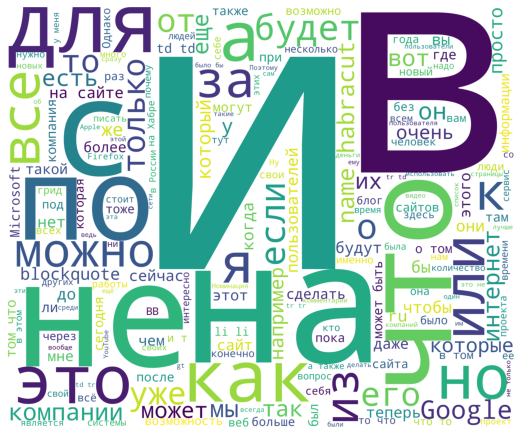

In [232]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')

plt.subplot(1, 2, 1)

In [233]:
# Количество уникальных слов в тексте
num_words = len(set(corpus))
num_words

31169

In [234]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\илья\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [235]:
from nltk.corpus import stopwords
from string import punctuation

In [236]:
russian_stopwords = stopwords.words("russian")

In [237]:
# Удаление знаков пунктуации из текста
def remove_punct(text):
    #table = str.maketrans('', '', string.punctuation)
    table = {33: ' ', 34: ' ', 35: ' ', 36: ' ', 37: ' ', 38: ' ', 39: ' ', 40: ' ', 41: ' ', 42: ' ', 43: ' ', 44: ' ', 45: ' ', 46: ' ', 47: ' ', 58: ' ', 59: ' ', 60: ' ', 61: ' ', 62: ' ', 63: ' ', 64: ' ', 91: ' ', 92: ' ', 93: ' ', 94: ' ', 95: ' ', 96: ' ', 123: ' ', 124: ' ', 125: ' ', 126: ' '}
    #print(table)
    return text.translate(table)

In [238]:
habrParse_df['Post_clean'] = habrParse_df['Post'].map(lambda x: x.lower())

In [239]:
habrParse_df['Post_clean'] = habrParse_df['Post_clean'].map(lambda x: remove_punct(x))

In [240]:
habrParse_df['Post_clean'] = habrParse_df['Post_clean'].map(lambda x: x.split(' '))

In [241]:
habrParse_df['Post_clean'] = habrParse_df['Post_clean'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                                  and token != " " \
                                                                  and token.strip() not in punctuation])

In [242]:
habrParse_df['Post_clean'] = habrParse_df['Post_clean'].map(lambda x: ' '.join(x))

In [243]:
habrParse_df.head()

,Post,hubs,Post_clean
0,Привет! Для сборника ответов на Часто Задаваем...,['Habr'],привет сборника ответов часто задаваемые вопро...
1,"Кроме неработающих и отсутствующих страниц, о ...",['Habr'],кроме неработающих отсутствующих страниц котор...
2,"Насколько я знаю, Google выбрал агентство «Мас...",['Чулан'],насколько знаю google выбрал агентство «маслов...
3,Мы планируем добавить в раздел «тексты» возмож...,['Habr'],планируем добавить раздел «тексты» возможность...
4,"У меня такое ощущение, что logout время от вре...",['Habr'],такое ощущение logout время времени происходит...


In [244]:
corpus_clean = get_corpus(habrParse_df['Post_clean'].values)
procWordCloud = get_wordCloud(corpus_clean)

In [245]:
# Количество уникальных слов в тексте
num_words = len(set(corpus_clean))
num_words

22721

<ipython-input-246-f610b4cd583d>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)


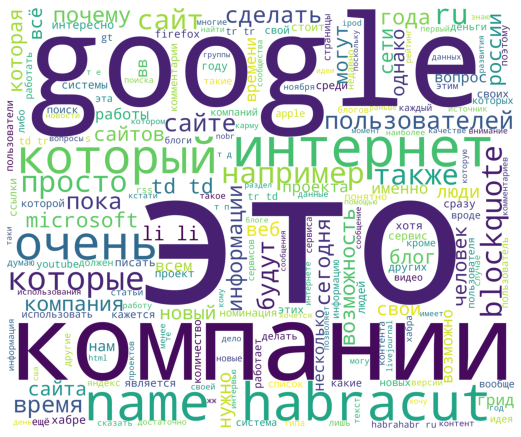

In [246]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')

plt.subplot(1, 2, 1)

In [247]:
df_habr = habrParse_df[['Post_clean', 'hubs']]

In [248]:
from ast import literal_eval

In [249]:
df_habr['hubs'] = df_habr['hubs'].map(lambda x: literal_eval(x))

<ipython-input-249-fd9073e57a47>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_habr['hubs'] = df_habr['hubs'].map(lambda x: literal_eval(x))


In [250]:
df_habr.head()

,Post_clean,hubs
0,привет сборника ответов часто задаваемые вопро...,[Habr]
1,кроме неработающих отсутствующих страниц котор...,[Habr]
2,насколько знаю google выбрал агентство «маслов...,[Чулан]
3,планируем добавить раздел «тексты» возможность...,[Habr]
4,такое ощущение logout время времени происходит...,[Habr]


In [251]:
df_habr['hubs'] = df_habr['hubs'].map(lambda x: x[0])

<ipython-input-251-41967ba0056a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_habr['hubs'] = df_habr['hubs'].map(lambda x: x[0])


In [252]:
df_habr.head()

,Post_clean,hubs
0,привет сборника ответов часто задаваемые вопро...,Habr
1,кроме неработающих отсутствующих страниц котор...,Habr
2,насколько знаю google выбрал агентство «маслов...,Чулан
3,планируем добавить раздел «тексты» возможность...,Habr
4,такое ощущение logout время времени происходит...,Habr


In [253]:
p = pd.DataFrame(df_habr['hubs'].value_counts())
#p.columns = ['hub', 'count']
p#.head()

,hubs
Чулан,284
Habr,235
IT-компании,175
Firefox,18
Статистика в IT,12
Поисковые технологии,11
Микроформаты,11
Социальные сети и сообщества,11
Я пиарюсь,10
Хостинг,9


In [254]:
p = p.loc[p['hubs'] > 100]
p

,hubs
Чулан,284
Habr,235
IT-компании,175


In [255]:
df_habr_clean = df_habr.loc[df_habr['hubs'].isin(['IT-компании', 'Habr', 'Управление медиа', 'Я пиарюсь'])]

In [256]:
df_habr_clean.head()

,Post_clean,hubs
0,привет сборника ответов часто задаваемые вопро...,Habr
1,кроме неработающих отсутствующих страниц котор...,Habr
3,планируем добавить раздел «тексты» возможность...,Habr
4,такое ощущение logout время времени происходит...,Habr
6,редактирование постов принципе трудно сделать ...,Habr


In [257]:
df_habr_clean.shape

(420, 2)

In [258]:
from sklearn.model_selection import train_test_split

In [259]:
X_train, X_valid, y_train, y_valid = train_test_split(df_habr_clean['Post_clean'], df_habr_clean['hubs'], test_size=0.1, random_state=42)

In [260]:
X_train.shape

(378,)

In [261]:
X_valid.shape

(42,)

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [263]:
X_train.shape

(302,)

In [264]:
X_test.shape

(76,)

In [265]:
from sklearn.pipeline import Pipeline
# pipeline позволяет объединить в один блок трансформер и модель, что упрощает написание кода и улучшает его читаемость
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
# линейный классификатор и классификатор методом ближайших соседей
from sklearn import metrics
# набор метрик для оценки качества модели
from sklearn.model_selection import GridSearchCV
# модуль поиска по сетке параметров

In [266]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))
])

In [267]:
knb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=4))
])

In [268]:
sgd_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('sgd_clf', SGDClassifier(random_state=42))])

In [269]:
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

        Habr       1.00      0.88      0.94        42
 IT-компании       0.89      1.00      0.94        34
   Я пиарюсь       0.00      0.00      0.00         0

    accuracy                           0.93        76
   macro avg       0.63      0.63      0.63        76
weighted avg       0.95      0.93      0.94        76



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [270]:
parameters = { 
              'sgd_clf__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'sgd_clf__class_weight':[None, 'balanced'],
              'sgd_clf__penalty':[None, 'l2', 'l1', 'elasticnet'],
              'tfidf__strip_accents':['ascii', 'unicode', None],
               'tfidf__ngram_range':[(1,2), (1,3), (1,4)]
              }
model = GridSearchCV(sgd_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train, y_train)

In [271]:
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_) 

Best score and parameter combination:
0.9008771929824562 {'sgd_clf__class_weight': None, 'sgd_clf__loss': 'hinge', 'sgd_clf__penalty': None, 'tfidf__ngram_range': (1, 3), 'tfidf__strip_accents': 'unicode'}


In [273]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 4), strip_accents='unicode')),
    ('sgd_clf', SGDClassifier(penalty='elasticnet', class_weight='balanced', random_state=42))
])

In [274]:
sgd_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 4), strip_accents='unicode')),
                ('sgd_clf',
                 SGDClassifier(class_weight='balanced', penalty='elasticnet',
                               random_state=42))])

In [275]:
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

        Habr       0.89      0.92      0.90        36
 IT-компании       0.95      0.95      0.95        38
   Я пиарюсь       0.00      0.00      0.00         2

    accuracy                           0.91        76
   macro avg       0.61      0.62      0.62        76
weighted avg       0.90      0.91      0.90        76



In [276]:
knb_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('knb_clf', KNeighborsClassifier(n_neighbors=4))])

In [277]:
predicted_sgd = knb_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

        Habr       0.97      0.80      0.88        45
 IT-компании       0.79      0.97      0.87        31
   Я пиарюсь       0.00      0.00      0.00         0

    accuracy                           0.87        76
   macro avg       0.59      0.59      0.58        76
weighted avg       0.90      0.87      0.87        76



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [278]:
predicted_sgd_val = sgd_ppl_clf.predict(X_valid)
print(metrics.classification_report(predicted_sgd_val, y_valid))

              precision    recall  f1-score   support

        Habr       0.95      0.95      0.95        20
 IT-компании       0.95      1.00      0.98        20
   Я пиарюсь       1.00      0.50      0.67         2

    accuracy                           0.95        42
   macro avg       0.97      0.82      0.86        42
weighted avg       0.95      0.95      0.95        42

